# **Model_S 01** - No data augmentation
Name: `Alberto Pingo` \
Email: `2202145`@my.ipleiria.pt 

Validation dataset: `train5` 

## Directories
This section sets up the directory paths used for training, validation, and test datasets based on the repository structure.

In [13]:
import os

current_dir = os.getcwd()

# TWO FOLDERS UP
data_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir, 'data'))
test_dir = os.path.join(data_dir, 'test')
train_dir = os.path.join(data_dir, 'train')

train_dirs = []
for i in range(1, 5):
    train_dirs.append(os.path.join(train_dir, 'train' + str(i)))


validation_dir = os.path.join(data_dir, 'train', 'train5')

print(current_dir)
print(data_dir)
print(test_dir)
print(train_dir)
print(validation_dir)

/home/pws/code/IA-image-classification/notebooks/models-S
/home/pws/code/IA-image-classification/data
/home/pws/code/IA-image-classification/data/test
/home/pws/code/IA-image-classification/data/train
/home/pws/code/IA-image-classification/data/train/train5


## Preprocessing
Load the datasets and perform initial preprocessing. Images are resized to 32x32 pixels and batched.

In [14]:

from keras.utils import image_dataset_from_directory
import tensorflow as tf

# Load training datasets from train1 to train4
train_datasets = []
IMG_SIZE = 32
BATCH_SIZE = 64
for i in range(1, 5):
    dataset = image_dataset_from_directory(train_dirs[i-1], image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical')
    train_datasets.append(dataset)
 
train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

# Load validation dataset
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical')


# Load test dataset
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical')

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Size of the datasets
print('Size of the datasets')

train_size = 0
for images, labels in train_dataset:
    train_size += len(labels)
print('train size:', train_size)

test_size = 0
for images, labels in test_dataset:
    test_size += len(labels)
print('test size:', test_size)

validation_size = 0
for images, labels in validation_dataset:
    validation_size += len(labels)
print('validation size:', validation_size)


Size of the datasets
train size: 40000
test size: 10000
validation size: 10000


## **Data Augmentation**

In [16]:
from keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.03),
    layers.RandomBrightness(0.03)
])

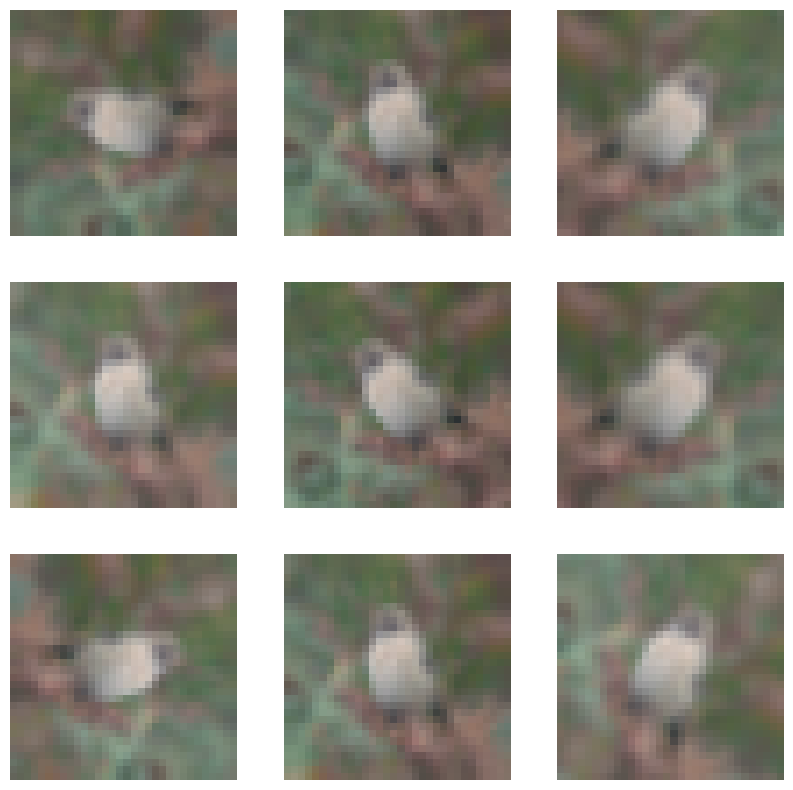

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, _ in train_dataset.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [18]:
# import matplotlib.pyplot as plt

# for data, _ in train_dataset.take(1):
#     for i in range(9):
#         plt.imshow(data[i].numpy().astype('uint8'))
#         plt.show()
#     break

# **MODEL ARCHITECTURE**

## Build a Convolutional Neural Network (CNN) model.

1. **Input Layer**
   - The input layer expects images of size 32x32 pixels with 3 color channels (RGB).

2. **Rescaling Layer**
   - Rescales the pixel values from the range [0, 255] to [0, 1].

3. **Convolutional Layers**
   - The model consists of 3 convolutional layers with 32, 64, and 128 filters, respectively.
   - The weight are initialized using the `he_normal` initializer.
   
4. **Max Pooling Layers**
   - Max pooling layers are used after each convolutional layer to reduce the spatial dimensions of the feature maps.
   - A pooling size of 2x2 with a stride of 2 is used.

5. **Dense Layer** 
   - The model has a dense layer with 256 units and ReLU activation function.
   - The purpose of this layer is to learn the complex patterns in the data.

6. **Output Layer**
   - The output layer consists of 10 units (one for each class) with a softmax activation function.
   - The softmax function outputs the probability distribution over the classes.

**Overfitting measures**
   - Dropout layers are used after each Convolutional and Dense layer to prevent overfitting.
   - Kernel Regularization is used to prevent overfitting.

**Batch Normalization**
   - Batch normalization is used after each Convolutional and Dense layer to normalize the activations of the previous layer at each batch.
   - This helps to stabilize and speed up the training process.

In [19]:

from tensorflow import keras
from keras import layers, models, regularizers

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, kernel_initializer='he_normal', activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation="softmax")(x)  # Softmax for multi-class classification

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                             

## Compile Model

**Loss function:** \
We use the *Categorical Crossentropy* loss function because it is a **multi-class classification** problem.

**Optimizer: Adam** \
We use the *Adam* optimizer because it is one of the best and most popular optimizers for neural networks.

In [20]:
# import Adam optimizer
from keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    metrics=['acc'])

## Train Model
Train the model with Early stopping, Model checkpoint, and Learning rate reduction callbacks.

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.3, 
    min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_acc', 
                           patience=10, 
                           restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/S01/checkpoints/S01-best_model.h5', save_best_only=True)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=[early_stop, model_checkpoint, learning_rate_reduction])

Epoch 1/100


2024-06-21 03:22:22.437662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-21 03:22:22.609606: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-21 03:22:23.701476: I external/local_xla/xla/service/service.cc:168] XLA service 0x7aa11c991630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-21 03:22:23.701505: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-06-21 03:22:23.706516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718936543.773946  147661 device_compiler.h:186] Compiled cluster using XLA

628/628 [==============================] - 16s 19ms/step - loss: 2.5096 - acc: 0.3101 - val_loss: 2.4401 - val_acc: 0.3541 - lr: 0.0010
Epoch 2/100
  7/628 [..............................] - ETA: 10s - loss: 2.2128 - acc: 0.3638

/home/pws/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


628/628 [==============================] - 11s 18ms/step - loss: 1.9522 - acc: 0.4525 - val_loss: 1.9438 - val_acc: 0.4775 - lr: 0.0010
Epoch 3/100
628/628 [==============================] - 11s 18ms/step - loss: 1.6807 - acc: 0.5326 - val_loss: 1.6502 - val_acc: 0.5502 - lr: 0.0010
Epoch 4/100
628/628 [==============================] - 11s 18ms/step - loss: 1.5062 - acc: 0.5784 - val_loss: 1.3334 - val_acc: 0.6376 - lr: 0.0010
Epoch 5/100
628/628 [==============================] - 11s 18ms/step - loss: 1.3833 - acc: 0.6155 - val_loss: 1.2232 - val_acc: 0.6684 - lr: 0.0010
Epoch 6/100
628/628 [==============================] - 11s 18ms/step - loss: 1.3052 - acc: 0.6384 - val_loss: 1.1518 - val_acc: 0.6885 - lr: 0.0010
Epoch 7/100
628/628 [==============================] - 11s 18ms/step - loss: 1.2494 - acc: 0.6587 - val_loss: 1.1046 - val_acc: 0.7060 - lr: 0.0010
Epoch 8/100
628/628 [==============================] - 11s 18ms/step - loss: 1.2147 - acc: 0.6704 - val_loss: 1.1323 - val_a

## Save Model

In [22]:
import datetime
import time

date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

keras.models.save_model(model, 'models/S01-DA-model_' + date + '.h5')

/tmp/ipykernel_147576/257620166.py:6: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, 'models/S01-DA-model_' + date + '.h5')


# **EVALUATE**

## Evaluate the model on the validation dataset.

In [23]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

  1/157 [..............................] - ETA: 2s - loss: 0.7529 - acc: 0.8438

157/157 [==============================] - 1s 5ms/step - loss: 0.5999 - acc: 0.8492
val_acc: 0.8492000102996826


## Training and Validation Curves
Plot the training and validation accuracy and loss curves.

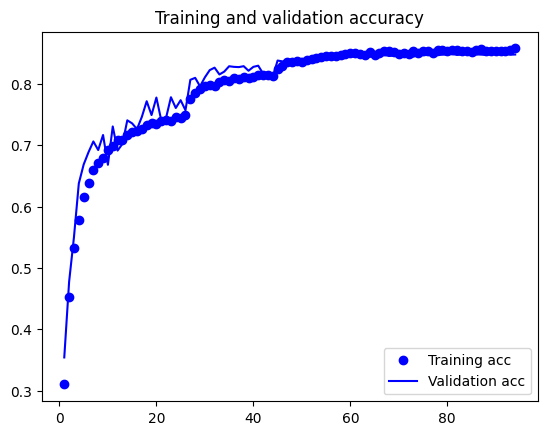

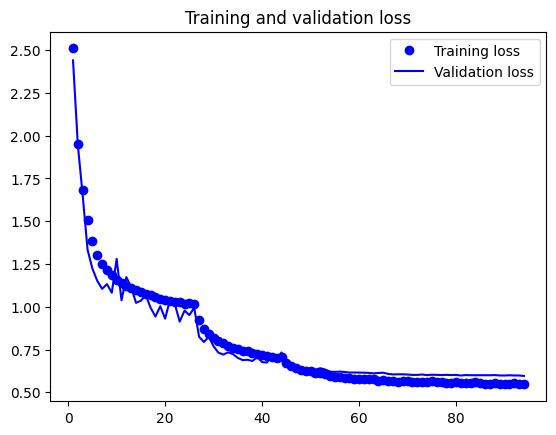

In [24]:

import matplotlib.pyplot as plt

# Extract the history from the training process
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Confusion Matrix

In [25]:
# confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = []
y_true = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels
    y_true.extend(np.argmax(labels, axis=1))       # True labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

1/1 [==============================] - 0s 94ms/step


In [26]:
# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[852  12  30  15  22   4   7   5  51  16]
 [  7 928   2   4   2   5   5   2  23  36]
 [ 28   0 713  41  65  44  38  14   7   2]
 [  7   0  29 722  34 147  45  17   9   6]
 [  5   1  28  42 858  18  25  17   3   0]
 [  4   0  16 115  27 821  11  28   3   0]
 [  5   1  16  28  12  12 897   2   6   1]
 [  8   0  20  34  35  40   6 828   3   3]
 [ 18   5   7   2   5   3   3   0 951   9]
 [ 19  41   1   7   2   1   3   6  20 922]]


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

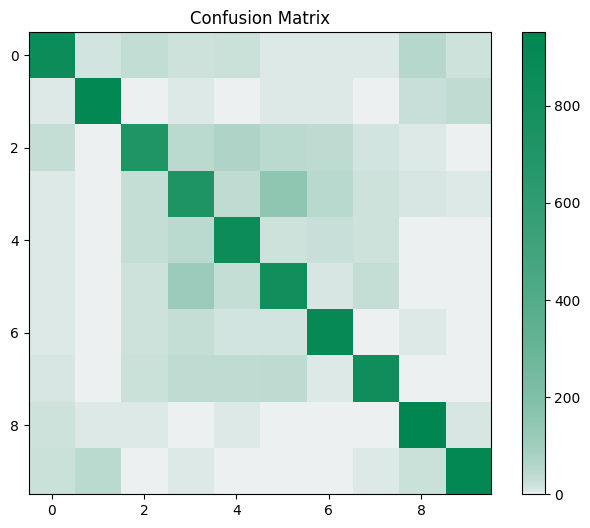

In [27]:

from matplotlib.colors import LinearSegmentedColormap

# Custom colormap
colors = ['#ecf0f1', '#008751']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256, gamma=0.5)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(validation_dataset.class_names))
plt.xticks(tick_marks, validation_dataset.class_names, rotation=45)
plt.yticks(tick_marks, validation_dataset.class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Predictions

Predict and visualize the results for a sample image.

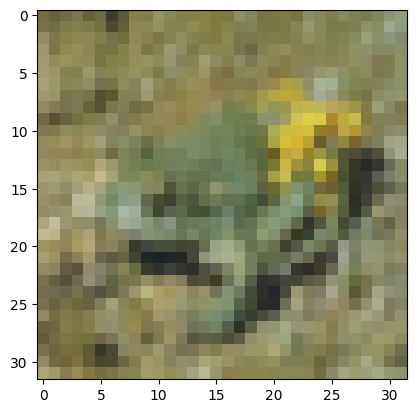

(1, 32, 32, 3)
1/1 [==============================] - 0s 157ms/step
Result:  [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Load an image
img = tf.keras.preprocessing.image.load_img(train_dirs[0] + '/006_frog/alytes_obstetricans_s_000179.png', target_size=(32, 32), interpolation='bilinear')
# img = tf.keras.preprocessing.image.load_img(train_dirs[0] + '/000_airplane/airbus_s_000012.png', target_size=(32, 32), interpolation='bilinear')

# Preprocess the image
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

plt.imshow(img)
plt.show()

print(img_array.shape)
result = model.predict(img_array)
print("Result: ", result.round())